
# **Synthetic dataset**

This function is used to generate synthetic classification datasets with specified characteristics, such as the number of samples, features, classes, and class distribution.

In [ ]:
from sklearn.datasets import make_classification

These lines import the pandas library and numpy library, which are commonly used for data manipulation and numerical computations, respectively

In [ ]:
import pandas as pd
import numpy as np

The Counter class from the collections module is imported to help count occurrences of elements, often used for analyzing class distributions in classification tasks.

In [ ]:
from collections import Counter

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X, y = make_classification(n_samples=100000, n_features=32, n_informative=32,n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)


**For example**, if y_train contains class labels [0, 0, 1, 1, 0, 1], Counter(y_train).items() would return something like [(0, 3), (1, 3)],
indicating that class 0 appears 3 times and class 1 appears 3 times in y_train.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")


The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79200 records for the majority class and 800 records for the minority class.


In [ ]:
X_train

array([[-3.75949643e+00, -3.78605852e-01, -1.46362879e+00, ...,
         2.70382420e+00,  1.78280865e+00,  2.63419776e-01],
       [-6.32129714e+00, -2.28430570e+00, -5.14184296e-01, ...,
        -3.08761234e+00, -2.13422351e-03,  3.06975030e+00],
       [ 3.63680373e+00,  5.81323126e+00, -3.81501159e-01, ...,
        -4.08324707e+00, -1.31913802e+00,  5.24207380e+00],
       ...,
       [ 2.11795713e+00, -6.87902640e+00, -1.34571204e+00, ...,
         3.31142601e+00, -7.73686609e-02, -6.67414603e+00],
       [-1.61331210e-01, -3.23563815e+00, -4.34442763e+00, ...,
        -3.89822446e-01, -1.21105090e+00, -9.30390350e-02],
       [ 2.21867298e-01, -1.21181512e+00, -3.19728190e+00, ...,
         5.88137865e+00, -2.40009494e+00, -1.94711318e+00]])

In [ ]:
X_train.shape

(80000, 32)

In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import classification_report

In [ ]:
# Keep only the normal data for the training dataset
X_train_normal = X_train[np.where(y_train == 0)]

# Input layer
input = keras.layers.Input(shape=(32,))

# Encoder layers
encoder = Sequential([
  Dense(16, activation='relu'),
  Dense(8, activation='relu'),
  Dense(4, activation='relu')])(input)

# Decoder layers
decoder = Sequential([
      Dense(8, activation="relu"),
      Dense(16, activation="relu"),
      Dense(32, activation="sigmoid")])(encoder)

# Create the autoencoder
autoencoder = keras.Model(inputs=input, outputs=decoder)


In [ ]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32)]              0         
                                                                 
 sequential_16 (Sequential)  (None, 4)                 700       
                                                                 
 sequential_17 (Sequential)  (None, 32)                728       
                                                                 
Total params: 1428 (5.58 KB)
Trainable params: 1428 (5.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mae')

# Fit the autoencoder
history = autoencoder.fit(X_train_normal, X_train_normal,
          epochs=2,
          batch_size=64,
          validation_data=(X_test, X_test),
          shuffle=True)


Epoch 1/2
1238/1238 [==============================] - 4s 2ms/step - loss: 2.5534 - val_loss: 2.5298
Epoch 2/2
1238/1238 [==============================] - 3s 2ms/step - loss: 2.5227 - val_loss: 2.5233


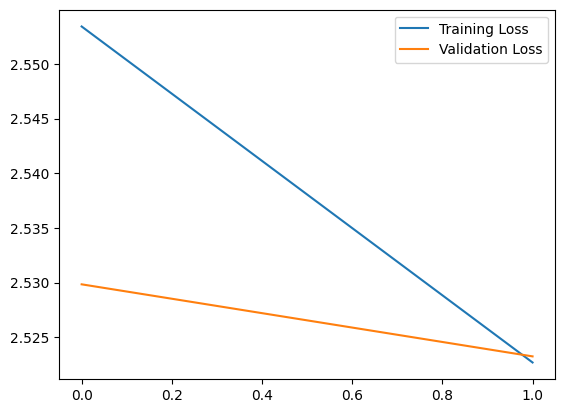

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()


625/625 [==============================] - 2s 3ms/step
The prediction loss threshold for 2% of outliers is 3.52


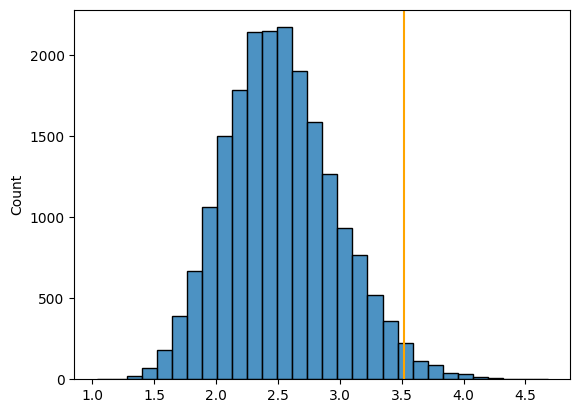

In [ ]:
# Predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)

# Get the mean absolute error between actual and reconstruction/prediction
prediction_loss = keras.losses.mae(prediction, X_test)

# Check the prediction loss threshold for 2% of outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')

# Visualize the threshold
sns.histplot(prediction_loss, bins=30, alpha=0.8)
plt.axvline(x=loss_threshold, color='orange')


In [ ]:
# Check the model performance at 2% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]

# # Check the prediction performance
print(classification_report(y_test, threshold_prediction))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19803
           1       0.00      0.01      0.00       197

    accuracy                           0.97     20000
   macro avg       0.50      0.49      0.49     20000
weighted avg       0.98      0.97      0.98     20000

